### Sentiment Analysis 

Overall Research Questions:
1) How do customers define 'good' service, and how does the new script shift those definitions?
2) What aspects of service (clarity, empathy, agent personality) drive variance in sentiment?
3) Does the new script systematically change perceptions or emotional tone, particularly for high-value segments like VOLT?

In addition, specific to sentiment analysis:

- Compare:
    - Sentiment distribution between treatment vs. control
    - Strength of sentiment for VOLT vs. general sample
- What topics co-occur with negative or positive sentiment?
- Any shifts in emotional tone driven by the new script?

Since our comment data was already cleaned (but still has some typos), it should be ready for sentiment analysis, using LTR_COMMENT_CLEAN.

An appropriate model is Google Cloud's Natural Language API. This model is quite robust and can handle typos and the extensive nuances of hastily typed, somewhat messy customer feedback, as similar text comprises a significant chuck of its training data.

"Google Cloud's Natural Language API is designed to handle natural, conversational text and can automatically detect language and process informal language patterns."

It's important to note that the text cleaning steps involved in sentiment analysis are far less than in topic modelling, as models such as this one adapt to punctuation, capitalization, and the natural organic communication patterns in our data.

See [API documentation](https://cloud.google.com/natural-language/docs/analyzing-sentiment)

In [7]:
# Load our data 
#
# exec(open('../scripts/setup.py').read()) # load our data/packages

#df = pd.read_pickle('../data/processed/data_with_sentiment_and_topics.pkl')


#### Step 1: Straight run of sentiment using Google Cloud API



In [3]:
# from google.cloud import language_v1
# import pandas as pd
# import numpy as np

# # Instantiate the client. The library will find your credentials automatically.
# client = language_v1.LanguageServiceClient()

# def analyze_sentiment(text):
#     """
#     Analyze sentiment for a given text using Google Cloud Natural Language API
#     Returns tuple of (score, magnitude) or (None, None) for null/empty text
#     """
#     if pd.isna(text) or text is None or str(text).strip() == '':
#         return None, None
    
#     try:
#         # Create the document object
#         document = language_v1.Document(
#             content=str(text),
#             type_=language_v1.Document.Type.PLAIN_TEXT,
#         )
        
#         # Call the API to analyze sentiment
#         sentiment = client.analyze_sentiment(document=document).document_sentiment
        
#         return sentiment.score, sentiment.magnitude
    
#     except Exception as e:
#         print(f"Error analyzing text: {str(text)[:50]}... Error: {e}")
#         return None, None

# # Apply sentiment analysis to the dataframe
# print("Analyzing sentiment for comments...")
# sentiment_results = df['LTR_COMMENT_CLEAN'].apply(analyze_sentiment)

# # Split the results into separate columns
# df['sentiment_score'] = sentiment_results.apply(lambda x: x[0])
# df['sentiment_magnitude'] = sentiment_results.apply(lambda x: x[1])

# print(f"Sentiment analysis complete. Added columns: sentiment_score, sentiment_magnitude")
# print(f"Non-null sentiment scores: {df['sentiment_score'].notna().sum()}")
# print(f"Sample results:")
# print(df[['LTR_COMMENT_CLEAN', 'sentiment_score', 'sentiment_magnitude']].head())

# UNCOMMENT ONLY WHEN YOU WANT TO RUN THE API CALL AGAIN

In [4]:
# Check sentiment analysis results, the cleaned comment and the sentiment scores, print all results
print("\nFull sentiment analysis results:")
for index, row in df.iterrows():
    print(f"Comment: {row['LTR_COMMENT_CLEAN']}")
    print(f"Sentiment Score: {row['sentiment_score']}, Magnitude: {row['sentiment_magnitude']}")
    print("-" * 80)



Full sentiment analysis results:


NameError: name 'df' is not defined

Sentiment score: ranges between -1.0 (negative) and 1.0 (positive) and corresponds to the overall emotional leaning of the text.

Magnitude: indicates the overall strength of emotion (both positive and negative) within the given text, between 0.0 and +inf. Unlike score, magnitude is not normalized for documentSentiment; each expression of emotion within the text (both positive and negative) contributes to the text's magnitude (so longer text blocks may have greater magnitudes)

The combination of the above two measures would allow:
- Transformation into a binary positive vs. negative encoding
- Use of a continuous sentiment measure
- Combination with magnitude enables a nuanced analysis of the informative longer comments that likely have more emotion attached to them (i.e. customers that took the time to write out a more lengthy response)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 582 entries, 45 to 646
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   GROUP                582 non-null    object        
 1   VOLT_FLAG            241 non-null    object        
 2   SURVEY_ID            582 non-null    object        
 3   SCORE                582 non-null    int64         
 4   LTR_COMMENT          430 non-null    object        
 5   PRIMARY_REASON       326 non-null    object        
 6   MONTH                582 non-null    datetime64[ns]
 7   CONNECTION_TIME      565 non-null    Int64         
 8   SALES_PERSON_SAT     534 non-null    Int64         
 9   SALES_FRIENDLY_SAT   558 non-null    Int64         
 10  COMMINICATION_SAT    562 non-null    Int64         
 11  FIRST_BILL_SAT       562 non-null    Int64         
 12  AGENT_KNOWLEDGE      568 non-null    Int64         
 13  VOLT_FLAG_BINARY     582 non-null    in


Calculating correlation between sentiment score and satisfaction metrics...
Correlation between sentiment score and CONNECTION_TIME: 0.6979
Correlation between sentiment score and SALES_PERSON_SAT: 0.7025
Correlation between sentiment score and SALES_FRIENDLY_SAT: 0.6609
Correlation between sentiment score and COMMINICATION_SAT: 0.6802
Correlation between sentiment score and FIRST_BILL_SAT: 0.6556
Correlation between sentiment score and AGENT_KNOWLEDGE: 0.7349

Correlation results:


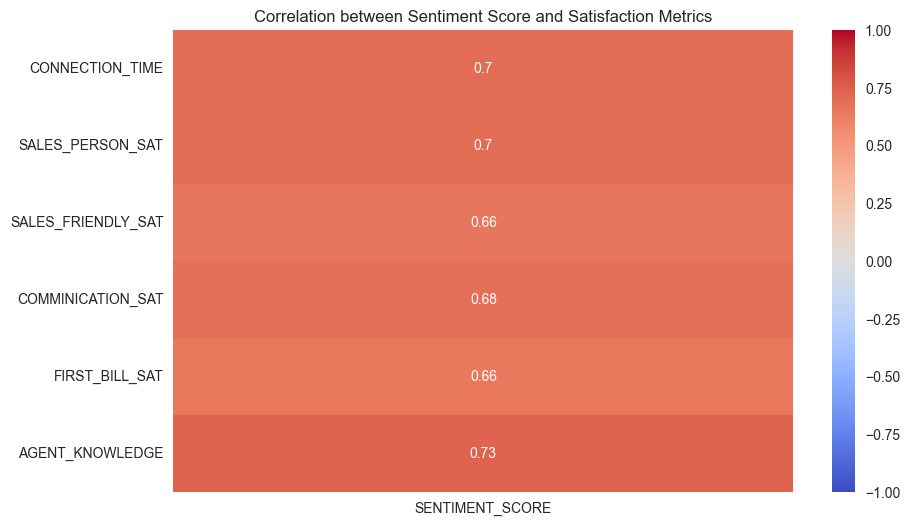

In [16]:
# Find the correlation between sentiment score and CONNECTION_TIME	SALES_PERSON_SAT	SALES_FRIENDLY_SAT	COMMINICATION_SAT	FIRST_BILL_SAT	AGENT_KNOWLEDGE
print("\nCalculating correlation between sentiment score and satisfaction metrics...")
correlation_metrics = ['CONNECTION_TIME', 'SALES_PERSON_SAT', 'SALES_FRIENDLY_SAT',
                       'COMMINICATION_SAT', 'FIRST_BILL_SAT', 'AGENT_KNOWLEDGE']
correlation_results = {}
for metric in correlation_metrics:
    if metric in df.columns:
        correlation = df['SENTIMENT_SCORE'].corr(df[metric])
        correlation_results[metric] = correlation
        print(f"Correlation between sentiment score and {metric}: {correlation:.4f}")
    else:
        print(f"Metric '{metric}' not found in dataframe columns.")
# Print the correlation results
print("\nCorrelation results:")

# Show in a heatmap visualization, set the scale to be between -1 and 1
import seaborn as sns
import matplotlib.pyplot as plt
correlation_df = pd.DataFrame(correlation_results, index=['SENTIMENT_SCORE']).T
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Correlation between Sentiment Score and Satisfaction Metrics')
plt.show()


In [13]:
# Rename the columns for clarity to be capitalized
df.rename(columns={
    'LTR_COMMENT_CLEAN': 'LTR_COMMENT_CLEAN',
    'sentiment_score': 'SENTIMENT_SCORE',
    'sentiment_magnitude': 'SENTIMENT_MAGNITUDE'
}, inplace=True)

In [ ]:
# Save our cleaned data as pickle for safekeeping
#df.to_pickle('../data/processed/data_with_sentiment.pkl')

In [33]:
# Define positive sentiment as that above 0.1 and negative sentiment as that below -0.1, the rest is neutral
df['SENTIMENT_POSITIVE'] = (df['SENTIMENT_SCORE'] > 0.1).astype(int)
df['SENTIMENT_NEGATIVE'] = (df['SENTIMENT_SCORE'] < -0.1).astype(int)
df['SENTIMENT_NEUTRAL'] = ((df['SENTIMENT_SCORE'] >= -0.1) & (df['SENTIMENT_SCORE'] <= 0.1)).astype(int)

# Check the distribution of sentiment categories
print("Sentiment Distribution:")
print(f"Positive: {df['SENTIMENT_POSITIVE'].sum()} ({df['SENTIMENT_POSITIVE'].mean():.2%})")
print(f"Negative: {df['SENTIMENT_NEGATIVE'].sum()} ({df['SENTIMENT_NEGATIVE'].mean():.2%})")
print(f"Neutral: {df['SENTIMENT_NEUTRAL'].sum()} ({df['SENTIMENT_NEUTRAL'].mean():.2%})")

# Check if we have the control variables we need
print("\nChecking for required variables:")
required_vars = ['VOLT', 'TREATMENT_FLAG']
for var in required_vars:
    if var in df.columns:
        print(f"✓ {var} found")
    else:
        print(f"✗ {var} not found")
        
print(f"\nDataframe shape: {df.shape}")
print(f"Available columns: {list(df.columns)}")

Sentiment Distribution:
Positive: 325 (55.84%)
Negative: 90 (15.46%)
Neutral: 13 (2.23%)

Checking for required variables:
✗ VOLT not found
✗ TREATMENT_FLAG not found

Dataframe shape: (582, 24)
Available columns: ['GROUP', 'VOLT_FLAG', 'SURVEY_ID', 'SCORE', 'LTR_COMMENT', 'PRIMARY_REASON', 'MONTH', 'CONNECTION_TIME', 'SALES_PERSON_SAT', 'SALES_FRIENDLY_SAT', 'COMMINICATION_SAT', 'FIRST_BILL_SAT', 'AGENT_KNOWLEDGE', 'VOLT_FLAG_BINARY', 'TREATMENT_BINARY', 'LTR_COMMENT_CLEAN', 'SENTIMENT_SCORE', 'SENTIMENT_MAGNITUDE', 'topics_assigned', 'substantive_topics', 'num_topics_assigned', 'SENTIMENT_POSITIVE', 'SENTIMENT_NEGATIVE', 'SENTIMENT_NEUTRAL']


In [34]:
### Linear Regression Model: Predicting Positive Sentiment from Topics

import statsmodels.api as sm
import pandas as pd
import numpy as np
from ast import literal_eval

# Process substantive_topics to create dummy variables
print("Processing substantive topics...")

# Convert string representations of lists to actual lists if needed
if df['substantive_topics'].dtype == 'object':
    try:
        df['substantive_topics'] = df['substantive_topics'].apply(
            lambda x: literal_eval(x) if isinstance(x, str) and x.startswith('[') else x
        )
    except:
        # If that fails, handle it differently
        df['substantive_topics'] = df['substantive_topics'].apply(
            lambda x: x if isinstance(x, list) else []
        )

# Get all unique topics across all comments
all_topics = set()
for topic_list in df['substantive_topics']:
    if isinstance(topic_list, list):
        all_topics.update(topic_list)

all_topics = list(all_topics)
print(f"Found {len(all_topics)} unique topics:", all_topics)

# Create dummy variables for each topic
topic_columns = []
for topic in all_topics:
    if topic:  # Skip empty topics
        # Clean topic name for column name
        topic_col = f"topic_{topic.replace(' ', '_').replace('/', '_').replace('&', 'and').lower()}"
        df[topic_col] = df['substantive_topics'].apply(
            lambda x: 1 if isinstance(x, list) and topic in x else 0
        )
        topic_columns.append(topic_col)

print(f"Created {len(topic_columns)} topic dummy variables")
print("Topic variables:", topic_columns)

# Check for control variables (VOLT and treatment)
control_vars = []
if 'VOLT_FLAG_BINARY' in df.columns:
    control_vars.append('VOLT_FLAG_BINARY')
    print("✓ VOLT_FLAG_BINARY found")
else:
    print("✗ VOLT_FLAG_BINARY not found")

if 'TREATMENT_BINARY' in df.columns:
    control_vars.append('TREATMENT_BINARY')
    print("✓ TREATMENT_BINARY found")
else:
    print("✗ TREATMENT_BINARY not found")

print(f"Control variables to include: {control_vars}")

# Prepare the data for regression (topics + controls)
regression_vars = topic_columns + control_vars + ['SENTIMENT_POSITIVE']
regression_data = df[regression_vars].dropna().copy()

print(f"Original dataset size: {len(df)}")
print(f"Regression dataset size (after removing missing values): {len(regression_data)}")

# Create interaction term between VOLT and treatment (if both exist)
interaction_var = None
if len(control_vars) >= 2:
    volt_var = 'VOLT_FLAG_BINARY'
    treatment_var = 'TREATMENT_BINARY'
    
    if volt_var in control_vars and treatment_var in control_vars:
        interaction_name = f'{volt_var}_X_{treatment_var}'
        regression_data[interaction_name] = (
            regression_data[volt_var] * regression_data[treatment_var]
        )
        interaction_var = interaction_name
        print(f"Created interaction term: {interaction_var}")
else:
    print("Insufficient control variables for interaction term")

# Define final predictors (topics + controls + interaction)
predictors = topic_columns + control_vars
if interaction_var:
    predictors.append(interaction_var)

print(f"Final predictors ({len(predictors)} total):")
print("Topic predictors:", [p for p in predictors if p.startswith('topic_')])
print("Control predictors:", [p for p in predictors if not p.startswith('topic_')])

# Convert all columns to standard numpy dtypes
print("\nConverting to standard dtypes...")
for col in predictors + ['SENTIMENT_POSITIVE']:
    if col in regression_data.columns:
        if regression_data[col].dtype in ['Int64', 'object']:
            regression_data[col] = regression_data[col].astype('float64')

# Remove any remaining NaN values
regression_data = regression_data.dropna()
print(f"Final regression dataset size: {len(regression_data)}")

# Check for topic prevalence (remove topics that appear in <5 cases)
print("\nTopic prevalence check:")
topic_vars_to_keep = []
for topic_var in [p for p in predictors if p.startswith('topic_')]:
    count = regression_data[topic_var].sum()
    if count >= 5:  # Keep topics with at least 5 cases
        topic_vars_to_keep.append(topic_var)
        print(f"✓ {topic_var}: {count} cases")
    else:
        print(f"✗ {topic_var}: {count} cases (removed - too few)")

# Update predictors to only include prevalent topics
final_predictors = topic_vars_to_keep + [p for p in predictors if not p.startswith('topic_')]
print(f"\nFinal model predictors ({len(final_predictors)} total): {final_predictors}")

Processing substantive topics...
Found 14 unique topics: ['Phone Support and Account Management', 'Field Engineer Performance', 'Pricing and Value Proposition', 'Installation Quality and Recommendations', 'Professional Service Standards', 'Contract Issues and Call Center Problems', 'Competitor Comparisons (Sky)', 'Broadband Service and Connectivity', 'Overall Customer Service Quality', 'Sales Agent Performance and Process', 'Service Speed and Network Coverage', 'Staff Helpfulness and Communication', 'Installation Process and Setup Experience', 'Service Delivery and Scheduling Issues']
Created 14 topic dummy variables
Topic variables: ['topic_phone_support_and_account_management', 'topic_field_engineer_performance', 'topic_pricing_and_value_proposition', 'topic_installation_quality_and_recommendations', 'topic_professional_service_standards', 'topic_contract_issues_and_call_center_problems', 'topic_competitor_comparisons_(sky)', 'topic_broadband_service_and_connectivity', 'topic_overall

In [44]:
# Model: Predicting Positive Sentiment from Topics
print("\n" + "="*80)
print("MODEL: PREDICTING POSITIVE SENTIMENT FROM EXTRACTED TOPICS")
print("="*80)

X_pos = regression_data[final_predictors]
y_pos = regression_data['SENTIMENT_POSITIVE']

# Add constant for intercept
X_pos_const = sm.add_constant(X_pos)

# Fit the model
model_positive = sm.OLS(y_pos, X_pos_const).fit()
print(model_positive.summary())

# Extract and display significant topic predictors
print("\n" + "="*60)
print("SIGNIFICANT TOPIC PREDICTORS (p < 0.05)")
print("="*60)

significant_topics = []
for var in final_predictors:
    if var.startswith('topic_') and model_positive.pvalues[var] < 0.05:
        coef = model_positive.params[var]
        pval = model_positive.pvalues[var]
        # Get original topic name
        original_topic = var.replace('topic_', '').replace('_', ' ').title()
        significant_topics.append((original_topic, coef, pval))
        print(f"✓ {original_topic}: coefficient = {coef:.4f} (p = {pval:.4f})")

if not significant_topics:
    print("No topics significantly predict positive sentiment at p < 0.05")

print(f"\n" + "="*60)
print("MODEL PERFORMANCE SUMMARY")
print("="*60)
print(f"R-squared: {model_positive.rsquared:.4f}")
print(f"Adjusted R-squared: {model_positive.rsquared_adj:.4f}")
print(f"F-statistic p-value: {model_positive.f_pvalue:.4f}")
print(f"Number of observations: {int(model_positive.nobs)}")
print(f"Number of topic predictors: {len([p for p in final_predictors if p.startswith('topic_')])}")
print(f"Number of significant topic predictors: {len(significant_topics)}")


MODEL: PREDICTING POSITIVE SENTIMENT FROM EXTRACTED TOPICS
                            OLS Regression Results                            
Dep. Variable:     SENTIMENT_POSITIVE   R-squared:                       0.329
Model:                            OLS   Adj. R-squared:                  0.308
Method:                 Least Squares   F-statistic:                     16.23
Date:                Thu, 07 Aug 2025   Prob (F-statistic):           7.84e-39
Time:                        02:38:45   Log-Likelihood:                -302.50
No. Observations:                 582   AIC:                             641.0
Df Residuals:                     564   BIC:                             719.6
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

In [45]:
# Model Interpretation and Summary - Topic-Based Positive Sentiment Prediction
print("\n" + "="*80)
print("TOPIC-BASED POSITIVE SENTIMENT MODEL INTERPRETATION")
print("="*80)

# Extract key statistics
print(f"\nMODEL PERFORMANCE:")
print(f"R-squared: {model_positive.rsquared:.4f}")
print(f"Adj. R-squared: {model_positive.rsquared_adj:.4f}")
print(f"F-statistic p-value: {model_positive.f_pvalue:.4f}")
print(f"Number of observations: {int(model_positive.nobs)}")

# All predictors with their effects
print(f"\nALL PREDICTORS AND THEIR EFFECTS:")
print("-" * 50)
for var in final_predictors:
    if var in model_positive.params.index:
        coef = model_positive.params[var]
        pval = model_positive.pvalues[var]
        significance = "***" if pval < 0.001 else "**" if pval < 0.01 else "*" if pval < 0.05 else ""
        
        if var.startswith('topic_'):
            # Topic variable
            original_topic = var.replace('topic_', '').replace('_', ' ').title()
            print(f"Topic - {original_topic}: {coef:+.4f} (p = {pval:.4f}) {significance}")
        else:
            # Control variable
            print(f"Control - {var}: {coef:+.4f} (p = {pval:.4f}) {significance}")

# Significant predictors summary
significant_vars = model_positive.pvalues[model_positive.pvalues < 0.05].index.tolist()
if 'const' in significant_vars:
    significant_vars.remove('const')

print(f"\nSIGNIFICANT PREDICTORS (p < 0.05): {len(significant_vars)}")
if significant_vars:
    for var in significant_vars:
        coef = model_positive.params[var]
        pval = model_positive.pvalues[var]
        if var.startswith('topic_'):
            original_topic = var.replace('topic_', '').replace('_', ' ').title()
            print(f"  ✓ {original_topic}: {coef:+.4f} (p = {pval:.4f})")
        else:
            print(f"  ✓ {var}: {coef:+.4f} (p = {pval:.4f})")

print(f"\n" + "="*80)
print("BUSINESS INSIGHTS")
print("="*80)

print(f"\n1. MODEL EXPLANATORY POWER:")
print(f"   - The extracted topics explain {model_positive.rsquared:.1%} of the variance in positive sentiment")
print(f"   - Model is {'significant' if model_positive.f_pvalue < 0.05 else 'not significant'} overall (F-test p = {model_positive.f_pvalue:.4f})")

# Topic-specific insights
topic_vars = [var for var in significant_vars if var.startswith('topic_')]
control_vars_sig = [var for var in significant_vars if not var.startswith('topic_')]

print(f"\n2. TOPIC INSIGHTS:")
if topic_vars:
    positive_topics = []
    negative_topics = []
    for var in topic_vars:
        coef = model_positive.params[var]
        original_topic = var.replace('topic_', '').replace('_', ' ').title()
        if coef > 0:
            positive_topics.append((original_topic, coef))
        else:
            negative_topics.append((original_topic, coef))
    
    if positive_topics:
        print(f"   Topics that INCREASE positive sentiment:")
        for topic, coef in positive_topics:
            print(f"     + {topic} (effect: +{coef:.3f})")
    
    if negative_topics:
        print(f"   Topics that DECREASE positive sentiment:")
        for topic, coef in negative_topics:
            print(f"     - {topic} (effect: {coef:.3f})")
else:
    print(f"   - No individual topics significantly predict positive sentiment")

print(f"\n3. CONTROL VARIABLE EFFECTS:")
if control_vars_sig:
    for var in control_vars_sig:
        coef = model_positive.params[var]
        pval = model_positive.pvalues[var]
        if 'VOLT' in var:
            print(f"   - VOLT customers: {'Higher' if coef > 0 else 'Lower'} positive sentiment (effect: {coef:+.4f})")
        elif 'TREATMENT' in var:
            print(f"   - Treatment group: {'Higher' if coef > 0 else 'Lower'} positive sentiment (effect: {coef:+.4f})")
        elif 'X_' in var:
            print(f"   - VOLT × Treatment interaction: {coef:+.4f} (p = {pval:.4f})")
else:
    print(f"   - No control variables significantly predict positive sentiment")

total_topics = len([p for p in final_predictors if p.startswith('topic_')])
print(f"\nNote: Analysis based on {total_topics} extracted topics and {len(regression_data)} observations with complete data.")


TOPIC-BASED POSITIVE SENTIMENT MODEL INTERPRETATION

MODEL PERFORMANCE:
R-squared: 0.3286
Adj. R-squared: 0.3083
F-statistic p-value: 0.0000
Number of observations: 582

ALL PREDICTORS AND THEIR EFFECTS:
--------------------------------------------------
Topic - Phone Support And Account Management: +0.1613 (p = 0.0583) 
Topic - Field Engineer Performance: +0.4669 (p = 0.0000) ***
Topic - Pricing And Value Proposition: +0.4200 (p = 0.0000) ***
Topic - Installation Quality And Recommendations: +0.3318 (p = 0.0029) **
Topic - Professional Service Standards: +0.1351 (p = 0.0577) 
Topic - Contract Issues And Call Center Problems: -0.3478 (p = 0.0000) ***
Topic - Competitor Comparisons (Sky): +0.3656 (p = 0.0029) **
Topic - Broadband Service And Connectivity: +0.3212 (p = 0.0007) ***
Topic - Overall Customer Service Quality: +0.3572 (p = 0.0000) ***
Topic - Sales Agent Performance And Process: +0.1941 (p = 0.0137) *
Topic - Service Speed And Network Coverage: +0.4379 (p = 0.0000) ***
Topic

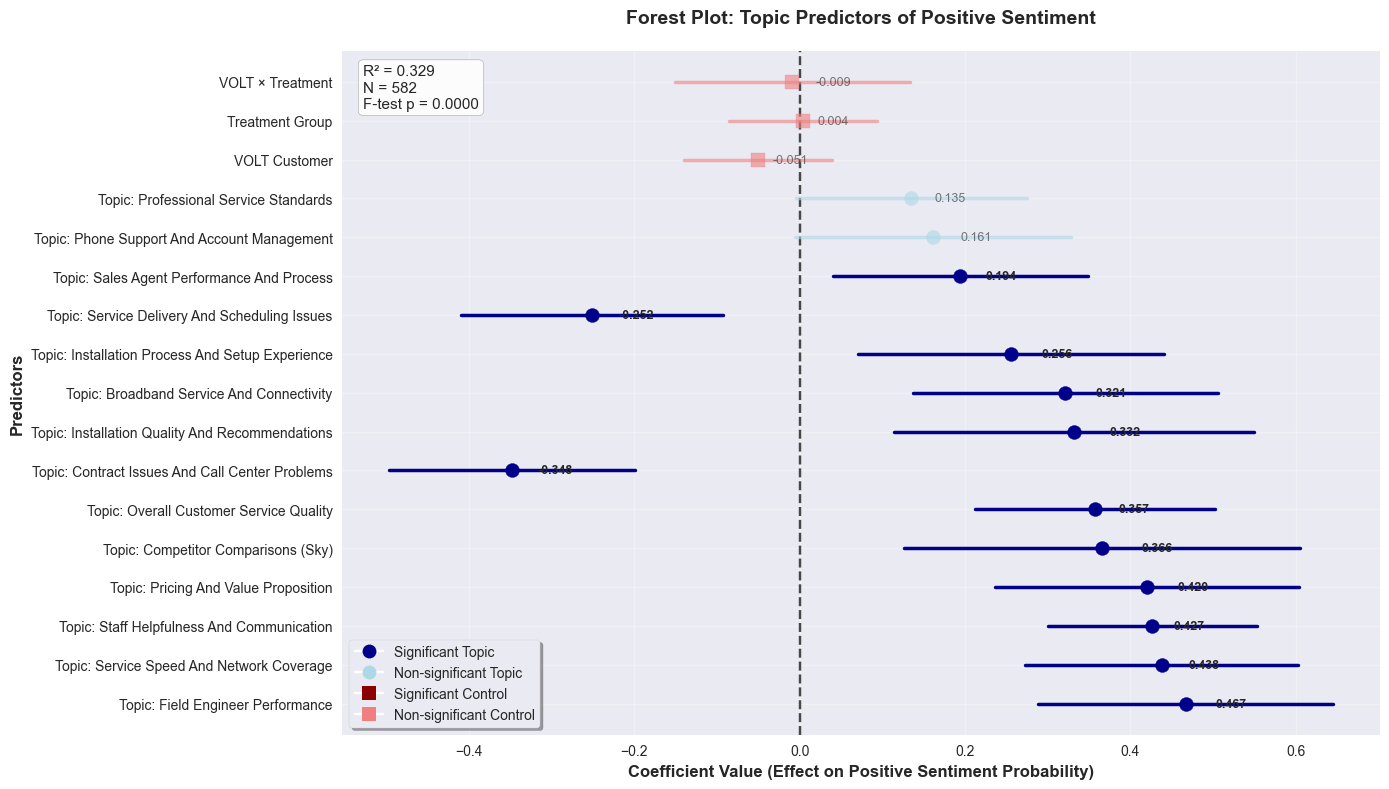


Topic-based forest plot created successfully!
Note: Circles = topics, Squares = control variables
Note: Dark colors = significant predictors (p < 0.05)


In [47]:
### Forest Plot Visualization - Topic Predictors of Positive Sentiment

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def create_topic_forest_plot(model, title="Forest Plot: Topic Predictors of Positive Sentiment"):
    """
    Create an academic-style forest plot showing topic coefficients and confidence intervals
    for positive sentiment prediction
    """
    
    # Extract coefficients and confidence intervals (excluding constant)
    params = model.params.drop('const') if 'const' in model.params.index else model.params
    conf_int = model.conf_int().drop('const') if 'const' in model.conf_int().index else model.conf_int()
    
    # Separate topic variables from control variables
    topic_vars = [var for var in params.index if var.startswith('topic_')]
    control_vars = [var for var in params.index if not var.startswith('topic_')]
    
    # Sort topic variables by coefficient magnitude
    topic_coeffs = [(var, params[var]) for var in topic_vars]
    topic_coeffs.sort(key=lambda x: abs(x[1]), reverse=True)
    
    # Combine sorted topics with control variables
    all_vars = [var for var, _ in topic_coeffs] + control_vars
    
    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=(14, max(8, len(all_vars) * 0.4)))
    
    y_pos = np.arange(len(all_vars))
    
    for i, var in enumerate(all_vars):
        coef = params[var]
        ci_lower = conf_int.loc[var, 0]
        ci_upper = conf_int.loc[var, 1]
        
        # Determine color and style based on variable type and significance
        p_val = model.pvalues[var]
        
        if var.startswith('topic_'):
            # Topic variable
            color = 'darkblue' if p_val < 0.05 else 'lightblue'
            marker = 'o'
            alpha = 1.0 if p_val < 0.05 else 0.6
        else:
            # Control variable
            color = 'darkred' if p_val < 0.05 else 'lightcoral'
            marker = 's'
            alpha = 1.0 if p_val < 0.05 else 0.6
        
        # Plot coefficient as point
        ax.scatter(coef, i, color=color, s=100, alpha=alpha, marker=marker, zorder=3)
        
        # Plot confidence interval as horizontal line
        ax.plot([ci_lower, ci_upper], [i, i], color=color, alpha=alpha, linewidth=2.5, zorder=2)
        
        # Add coefficient value as text
        ax.text(coef + (ci_upper - ci_lower) * 0.1, i, f'{coef:.3f}', 
                va='center', ha='left', fontsize=9, alpha=alpha, weight='bold' if p_val < 0.05 else 'normal')
    
    # Formatting
    ax.axvline(x=0, color='black', linestyle='--', alpha=0.7, zorder=1)
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('Coefficient Value (Effect on Positive Sentiment Probability)', fontsize=12, weight='bold')
    ax.set_ylabel('Predictors', fontsize=12, weight='bold')
    
    # Create clean labels
    clean_labels = []
    for var in all_vars:
        if var.startswith('topic_'):
            # Clean topic name
            clean_name = var.replace('topic_', '').replace('_', ' ').title()
            clean_labels.append(f"Topic: {clean_name}")
        else:
            # Control variable
            if 'X_' in var:
                clean_labels.append("VOLT × Treatment")
            elif 'TREATMENT' in var:
                clean_labels.append("Treatment Group")
            elif 'VOLT_FLAG' in var:
                clean_labels.append("VOLT Customer")
            else:
                clean_labels.append(var.replace('_', ' ').title())
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(clean_labels, fontsize=10)
    
    # Title and model statistics
    ax.set_title(title, fontsize=14, weight='bold', pad=20)
    
    # Add model statistics
    r2 = model.rsquared
    n = int(model.nobs)
    f_pval = model.f_pvalue
    
    stats_text = f'R² = {r2:.3f}\nN = {n}\nF-test p = {f_pval:.4f}'
    ax.text(0.02, 0.98, stats_text, 
            transform=ax.transAxes, va='top', ha='left',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='gray'),
            fontsize=11)
    
    # Add legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='darkblue', markersize=10, label='Significant Topic'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue', markersize=10, label='Non-significant Topic'),
        Line2D([0], [0], marker='s', color='w', markerfacecolor='darkred', markersize=10, label='Significant Control'),
        Line2D([0], [0], marker='s', color='w', markerfacecolor='lightcoral', markersize=10, label='Non-significant Control')
    ]
    ax.legend(handles=legend_elements, loc='lower left', frameon=True, fancybox=True, shadow=True)
    
    plt.tight_layout()
    return fig

# Create and display the forest plot
if 'model_positive' in locals():
    topic_forest_fig = create_topic_forest_plot(model_positive)
    plt.show()
    
    # Save the plot
    # topic_forest_fig.savefig('../results/topic_sentiment_forest_plot.png', dpi=300, bbox_inches='tight')
    print("\nTopic-based forest plot created successfully!")
    print("Note: Circles = topics, Squares = control variables")
    print("Note: Dark colors = significant predictors (p < 0.05)")
else:
    print("Model not available. Please run the regression model first.")

In [ ]:
### Filter Comments by Key Substantive Topics

# Define the topics of interest based on model results
positive_topics = {
    'Field Engineer Performance': 0.467,
    'Service Speed And Network Coverage': 0.439,
    'Staff Helpfulness And Communication': 0.427,
    'Pricing And Value Proposition': 0.408
}

negative_topics = {
    'Service Delivery And Scheduling Issues': -0.252,
    'Contract Issues And Call Center Problems': -0.348
}

all_key_topics = {**positive_topics, **negative_topics}

print("="*80)
print("FILTERING COMMENTS BY KEY SUBSTANTIVE TOPICS")
print("="*80)

# Function to check if a comment contains any of the specified topics
def contains_topic(topics_list, target_topics):
    """Check if any of the target topics appear in the topics list"""
    if not isinstance(topics_list, list):
        return False
    return any(topic in target_topics for topic in topics_list)

# Filter comments for each topic category
print("\n🟢 POSITIVE IMPACT TOPICS:")
print("-" * 50)

for topic_name, coefficient in positive_topics.items():
    # Filter comments that contain this topic
    topic_comments = df[df['substantive_topics'].apply(
        lambda x: isinstance(x, list) and topic_name in x
    )]
    
    print(f"\n📋 {topic_name.upper()} (Coefficient: +{coefficient:.3f})")
    print(f"Found {len(topic_comments)} comments")
    
    if len(topic_comments) > 0:
        # Show sentiment distribution for this topic
        positive_count = topic_comments['SENTIMENT_POSITIVE'].sum()
        negative_count = topic_comments['SENTIMENT_NEGATIVE'].sum()
        neutral_count = topic_comments['SENTIMENT_NEUTRAL'].sum()
        
        print(f"Sentiment Distribution: {positive_count} positive, {negative_count} negative, {neutral_count} neutral")
        
        # Show a few example comments
        print("\nExample comments:")
        sample_comments = topic_comments[['LTR_COMMENT_CLEAN', 'SENTIMENT_SCORE', 'TREATMENT_BINARY', 'VOLT_FLAG_BINARY']].head(3)
        
        for idx, row in sample_comments.iterrows():
            treatment = "Treatment" if row['TREATMENT_BINARY'] == 1 else "Control"
            volt = "VOLT" if row['VOLT_FLAG_BINARY'] == 1 else "Regular"
            print(f"  • [{treatment}/{volt}] Sentiment: {row['SENTIMENT_SCORE']:.2f}")
            print(f"    \"{row['LTR_COMMENT_CLEAN']}\"")
            print()

print("\n" + "="*50)
print("\n🔴 NEGATIVE IMPACT TOPICS:")
print("-" * 50)

for topic_name, coefficient in negative_topics.items():
    # Filter comments that contain this topic
    topic_comments = df[df['substantive_topics'].apply(
        lambda x: isinstance(x, list) and topic_name in x
    )]
    
    print(f"\n📋 {topic_name.upper()} (Coefficient: {coefficient:.3f})")
    print(f"Found {len(topic_comments)} comments")
    
    if len(topic_comments) > 0:
        # Show sentiment distribution for this topic
        positive_count = topic_comments['SENTIMENT_POSITIVE'].sum()
        negative_count = topic_comments['SENTIMENT_NEGATIVE'].sum()
        neutral_count = topic_comments['SENTIMENT_NEUTRAL'].sum()
        
        print(f"Sentiment Distribution: {positive_count} positive, {negative_count} negative, {neutral_count} neutral")
        
        # Show a few example comments
        print("\nExample comments:")
        sample_comments = topic_comments[['LTR_COMMENT_CLEAN', 'SENTIMENT_SCORE', 'TREATMENT_BINARY', 'VOLT_FLAG_BINARY']].head(3)
        
        for idx, row in sample_comments.iterrows():
            treatment = "Treatment" if row['TREATMENT_BINARY'] == 1 else "Control"
            volt = "VOLT" if row['VOLT_FLAG_BINARY'] == 1 else "Regular"
            print(f"  • [{treatment}/{volt}] Sentiment: {row['SENTIMENT_SCORE']:.2f}")
            print(f"    \"{row['LTR_COMMENT_CLEAN']}\"")
            print()

In [ ]:
### Treatment vs Control Analysis for Key Topics

print("\n" + "="*80)
print("TREATMENT vs CONTROL COMPARISON FOR KEY TOPICS")
print("="*80)

# Create a summary dataframe for analysis
topic_analysis = []

for topic_name, coefficient in all_key_topics.items():
    # Filter comments that contain this topic
    topic_comments = df[df['substantive_topics'].apply(
        lambda x: isinstance(x, list) and topic_name in x
    )]
    
    if len(topic_comments) > 0:
        # Split by treatment group
        control_comments = topic_comments[topic_comments['TREATMENT_BINARY'] == 0]
        treatment_comments = topic_comments[topic_comments['TREATMENT_BINARY'] == 1]
        
        # Calculate sentiment metrics for each group
        control_avg_sentiment = control_comments['SENTIMENT_SCORE'].mean() if len(control_comments) > 0 else 0
        treatment_avg_sentiment = treatment_comments['SENTIMENT_SCORE'].mean() if len(treatment_comments) > 0 else 0
        
        control_positive_rate = control_comments['SENTIMENT_POSITIVE'].mean() if len(control_comments) > 0 else 0
        treatment_positive_rate = treatment_comments['SENTIMENT_POSITIVE'].mean() if len(treatment_comments) > 0 else 0
        
        topic_analysis.append({
            'Topic': topic_name,
            'Coefficient': coefficient,
            'Impact': 'Positive' if coefficient > 0 else 'Negative',
            'Total_Comments': len(topic_comments),
            'Control_Count': len(control_comments),
            'Treatment_Count': len(treatment_comments),
            'Control_Avg_Sentiment': control_avg_sentiment,
            'Treatment_Avg_Sentiment': treatment_avg_sentiment,
            'Control_Positive_Rate': control_positive_rate,
            'Treatment_Positive_Rate': treatment_positive_rate,
            'Sentiment_Difference': treatment_avg_sentiment - control_avg_sentiment,
            'Positive_Rate_Difference': treatment_positive_rate - control_positive_rate
        })

# Convert to DataFrame for easier analysis
analysis_df = pd.DataFrame(topic_analysis)

print("\nSUMMARY TABLE:")
print("-" * 120)
print(f"{'Topic':<40} {'Coeff':<8} {'Total':<6} {'Ctrl':<5} {'Trt':<5} {'Ctrl_Sent':<10} {'Trt_Sent':<10} {'Diff':<8}")
print("-" * 120)

for _, row in analysis_df.iterrows():
    print(f"{row['Topic']:<40} {row['Coefficient']:>7.3f} {row['Total_Comments']:>5} {row['Control_Count']:>4} {row['Treatment_Count']:>4} "
          f"{row['Control_Avg_Sentiment']:>9.3f} {row['Treatment_Avg_Sentiment']:>9.3f} {row['Sentiment_Difference']:>7.3f}")

print("\n📊 KEY INSIGHTS:")
print("-" * 50)

# Find topics where treatment shows improvement
improved_topics = analysis_df[analysis_df['Sentiment_Difference'] > 0.05]  # Meaningful difference threshold
declined_topics = analysis_df[analysis_df['Sentiment_Difference'] < -0.05]

if len(improved_topics) > 0:
    print("\n🟢 Topics where TREATMENT group shows higher sentiment:")
    for _, row in improved_topics.iterrows():
        print(f"  • {row['Topic']}: +{row['Sentiment_Difference']:.3f} sentiment improvement")

if len(declined_topics) > 0:
    print("\n🔴 Topics where TREATMENT group shows lower sentiment:")
    for _, row in declined_topics.iterrows():
        print(f"  • {row['Topic']}: {row['Sentiment_Difference']:.3f} sentiment decline")

# VOLT vs Regular customer analysis for key topics
print(f"\n" + "="*60)
print("VOLT vs REGULAR CUSTOMER ANALYSIS")
print("="*60)

for topic_name in list(positive_topics.keys())[:2]:  # Analyze top 2 positive topics
    topic_comments = df[df['substantive_topics'].apply(
        lambda x: isinstance(x, list) and topic_name in x
    )]
    
    if len(topic_comments) > 0:
        volt_comments = topic_comments[topic_comments['VOLT_FLAG_BINARY'] == 1]
        regular_comments = topic_comments[topic_comments['VOLT_FLAG_BINARY'] == 0]
        
        print(f"\n📋 {topic_name.upper()}:")
        print(f"  VOLT customers: {len(volt_comments)} comments, avg sentiment: {volt_comments['SENTIMENT_SCORE'].mean():.3f}")
        print(f"  Regular customers: {len(regular_comments)} comments, avg sentiment: {regular_comments['SENTIMENT_SCORE'].mean():.3f}")
        
        if len(volt_comments) > 0 and len(regular_comments) > 0:
            diff = volt_comments['SENTIMENT_SCORE'].mean() - regular_comments['SENTIMENT_SCORE'].mean()
            print(f"  Difference: {diff:+.3f} ({'VOLT higher' if diff > 0 else 'Regular higher'})")

print(f"\nAnalysis complete! Review the treatment effects and customer segment differences above.")